# Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import cv2
from get_landmarks import get_landmarks
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from sklearn.model_selection import train_test_split

2024-05-27 20:53:25.452039: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Extraction

In [2]:
path = "clean_data/TEST_TRAIN/"
poses = [os.path.basename(d) for d in glob.glob("clean_data/TEST_TRAIN/*")]

all_imgs_path = []
for pose in poses:
    curr_path = path + pose + "/"
    all_imgs_path += (glob.glob(f"{curr_path}*"))

In [3]:
# # Do Not Run unless necessary!
# data = []
# for path in tqdm(all_imgs_path, desc="Processing Images..."):
#     landmarks = get_landmarks(cv2.imread(path))
#     landmarks.append(path)
#     data.append(landmarks)

# df = pd.DataFrame(data)

# df.to_csv("raw_kp_data.csv")

In [4]:
df = pd.read_csv("raw_kp_data.csv")
df = df.drop(df.columns[0], axis=1)
columns = []
for lmk in [f"lmk{x}" for x in range(33)]:
    for each in ["x", "y"]:
        columns.append(f"{lmk}_{each}")
columns.append("file_name")

df = df.rename(columns=dict(zip(df.columns, columns)))
df.head(3)

,lmk0_x,lmk0_y,lmk1_x,lmk1_y,lmk2_x,lmk2_y,lmk3_x,lmk3_y,lmk4_x,lmk4_y,...,lmk28_y,lmk29_x,lmk29_y,lmk30_x,lmk30_y,lmk31_x,lmk31_y,lmk32_x,lmk32_y,file_name
0,0.385088,0.702528,0.364045,0.705285,0.361666,0.700772,0.359247,0.696249,0.364545,0.705934,...,0.768468,0.898328,0.851075,0.870051,0.811650,0.781881,0.930616,0.763475,0.904605,clean_data/TEST_TRAIN/downdog/00000372.jpg
1,0.715758,0.547609,0.729912,0.527488,0.729571,0.523913,0.728997,0.520017,0.728891,0.527579,...,0.664694,0.307465,0.655862,0.261937,0.680302,0.380548,0.670513,0.336641,0.713165,clean_data/TEST_TRAIN/downdog/00000414.jpg
2,0.530292,0.608646,0.514618,0.623104,0.510664,0.621608,0.506621,0.619859,0.517501,0.626247,...,0.729783,0.889003,0.781900,0.853871,0.763474,0.806643,0.812826,0.792238,0.797374,clean_data/TEST_TRAIN/downdog/00000158.jpg


In [5]:
# Create df_X and df_y from df

df["pose"] = df["file_name"].apply(lambda x: x.split("/")[2])
df["pose"] = df["pose"].astype("category")
df_X = df.drop(columns=["pose", "file_name"])
df_y = df["pose"]

# Preprocessing Pipeline

1. Drop landmarks 1, 3, 4, 6
2. Scale

In [6]:
# lmk_to_drop = [1, 3, 4, 6]
# cols_to_drop = []
# for lmk in lmk_to_drop:
#     for each in ["x", "y"]:
#         cols_to_drop.append(f"lmk{str(lmk)}_{each}")

# x
cols_to_drop = [2,3,6,7,8,9,12,13]
cols_to_scale = [_ for _ in range(0,56)]

transformers = [
    ("drop", "drop", cols_to_drop),
    ("scale", StandardScaler(), cols_to_scale)
]

column_transformer = ColumnTransformer(transformers=transformers, remainder="passthrough")

pipeline = make_pipeline(
    column_transformer
)

X = pipeline.fit_transform(np.array(df_X))

# y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_y)
y_ohe = tf.keras.utils.to_categorical(y_encoded)


In [7]:
label_encoder.classes_

array(['downdog', 'goddess', 'plank', 'tree_chest', 'tree_up',
       'warrior2_left', 'warrior2_right'], dtype=object)

### Simple NN

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [9]:
X = pipeline.fit_transform(df_X)
y = y_ohe
y_cat = pd.array(df_y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [10]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=[X_train.shape[1]]))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(len(poses), activation="softmax"))

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,143 (74.78 KB)

 Trainable params: 19,143 (74.78 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history2 = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),
                     verbose=True)

Epoch 1/30


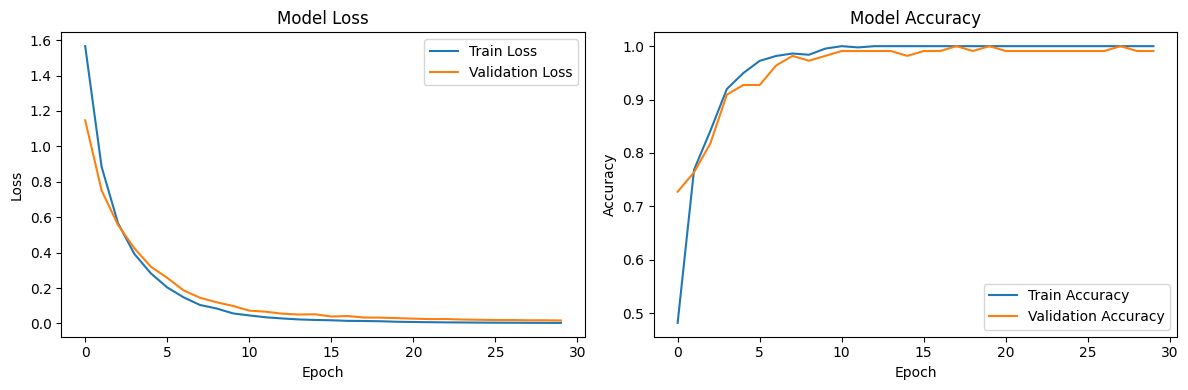

In [210]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history2)

In [211]:
model.save("nn_v1.h5")
dump(pipeline, "pipeline.pkl")

/Users/homemasaki/.pyenv/versions/3.10.6/envs/yoga-pose-detector/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['pipeline.pkl']

In [214]:
test_x = [0.7785290479660034, 0.4832121431827545, 0.7830552458763123, 0.4151889681816101, 0.7889384031295776, 0.41501256823539734, 0.7940126657485962, 0.4139469265937805, 0.756016194820404, 0.406649112701416, 0.738251805305481, 0.40033650398254395, 0.7211233973503113, 0.3947894275188446, 0.7651284337043762, 0.42292752861976624, 0.6652698516845703, 0.4063374698162079, 0.7728575468063354, 0.5575770735740662, 0.7384786009788513, 0.5552400350570679, 0.791469931602478, 0.80889493227005, 0.49392086267471313, 0.6987708210945129, 0.8370208740234375, 1.2483820915222168, 0.4829091429710388, 1.1308434009552002, 0.8286651372909546, 1.5521538257598877, 0.7084714770317078, 1.228020191192627, 0.8400972485542297, 1.6683650016784668, 0.7544735670089722, 1.3026577234268188, 0.8199907541275024, 1.6486468315124512, 0.771265983581543, 1.2606130838394165, 0.8103811144828796, 1.60910964012146, 0.7422195076942444, 1.0721982717514038, 0.7138510942459106, 1.6696432828903198, 0.5159143805503845, 1.6859114170074463, 0.7002948522567749, 2.398073673248291, 0.502536416053772, 2.411130666732788, 0.677778422832489, 3.0748956203460693, 0.4849456250667572, 3.098097085952759, 0.6624965071678162, 3.176849365234375, 0.45107030868530273, 3.2099833488464355, 0.7144500017166138, 3.2675459384918213, 0.5675069689750671, 3.2661046981811523]
len(test_x)

66

In [215]:
np.array(test_x)

array([0.77852905, 0.48321214, 0.78305525, 0.41518897, 0.7889384 ,
       0.41501257, 0.79401267, 0.41394693, 0.75601619, 0.40664911,
       0.73825181, 0.4003365 , 0.7211234 , 0.39478943, 0.76512843,
       0.42292753, 0.66526985, 0.40633747, 0.77285755, 0.55757707,
       0.7384786 , 0.55524004, 0.79146993, 0.80889493, 0.49392086,
       0.69877082, 0.83702087, 1.24838209, 0.48290914, 1.1308434 ,
       0.82866514, 1.55215383, 0.70847148, 1.22802019, 0.84009725,
       1.668365  , 0.75447357, 1.30265772, 0.81999075, 1.64864683,
       0.77126598, 1.26061308, 0.81038111, 1.60910964, 0.74221951,
       1.07219827, 0.71385109, 1.66964328, 0.51591438, 1.68591142,
       0.70029485, 2.39807367, 0.50253642, 2.41113067, 0.67777842,
       3.07489562, 0.48494563, 3.09809709, 0.66249651, 3.17684937,
       0.45107031, 3.20998335, 0.71445   , 3.26754594, 0.56750697,
       3.2661047 ])

In [221]:
test_x_scaled = pipeline.transform(np.array([test_x]))


1/1 [==============================] - 0s 21ms/step


5

In [5]:
load("models/nn_v1.h5")

KeyError: 72